In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils.utils as ut
import networkx as nx

In [3]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.4.0+cu124


In [4]:
torch.cuda.is_available()

True

In [28]:
sample_1 = [
    'ATGCATGCATTGCTTAGCATGCTAGCGCGCATCCTGG',
    'GGGCGCTCGTAGCTAGTAACGTCGCTAACTATCCATG',
    'CTGATGCATGCTGATATATATATATCTGATGCTAGAG',
    'ATCGATACGATGCTAGCTAGCATGCATATATATATCG',
    'ACACACGGGGGTAGATCGTTAGAAACATGCATGTACG',
    'ACTGATCGATGCATGCATCAGCTACATGCATCACCGG'
]

In [29]:
sample_2 = [
    'AGGAGAGAGGAGAGCGGCGCGCGGAGCGTTAGCTA',
    'AGCTAGTCGATCGTAGTCGACTACGATCGCGCGCG',
    'AGCTGCTACGATGCTCGGCGCGATATTATAGCATC',
    'TTTGTGCCCCTCGTAACTACGTCATCGACTAGCTA',
    'ATCTATCGTGCATTACTCCCCCCCCCCCCCCCATA'
]

In [30]:
dbg_1 = ut.build_DBG(*sample_1, k=21)
dbg_2 = ut.build_DBG(*sample_2, k=21)

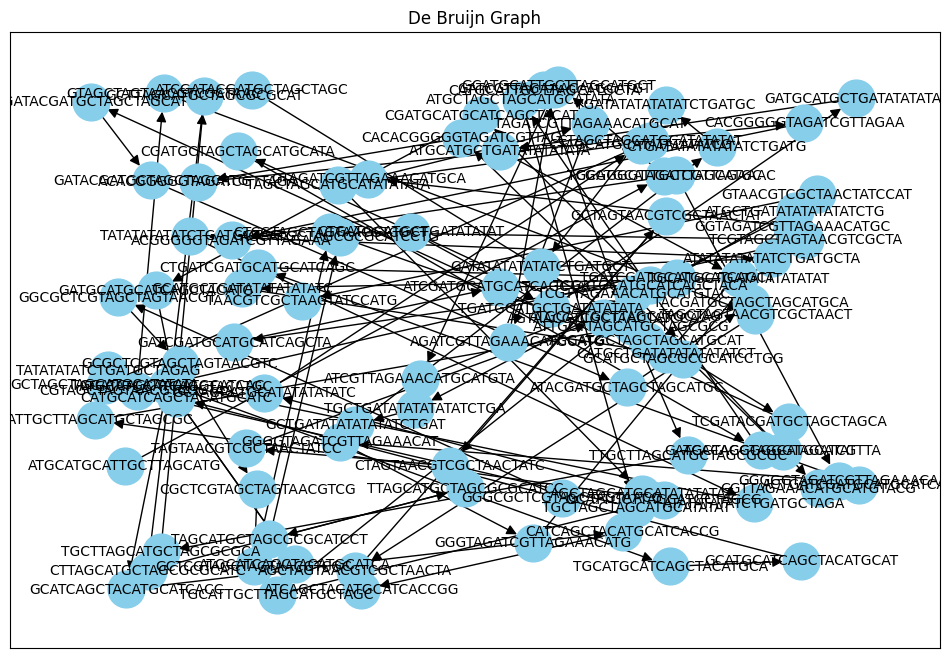

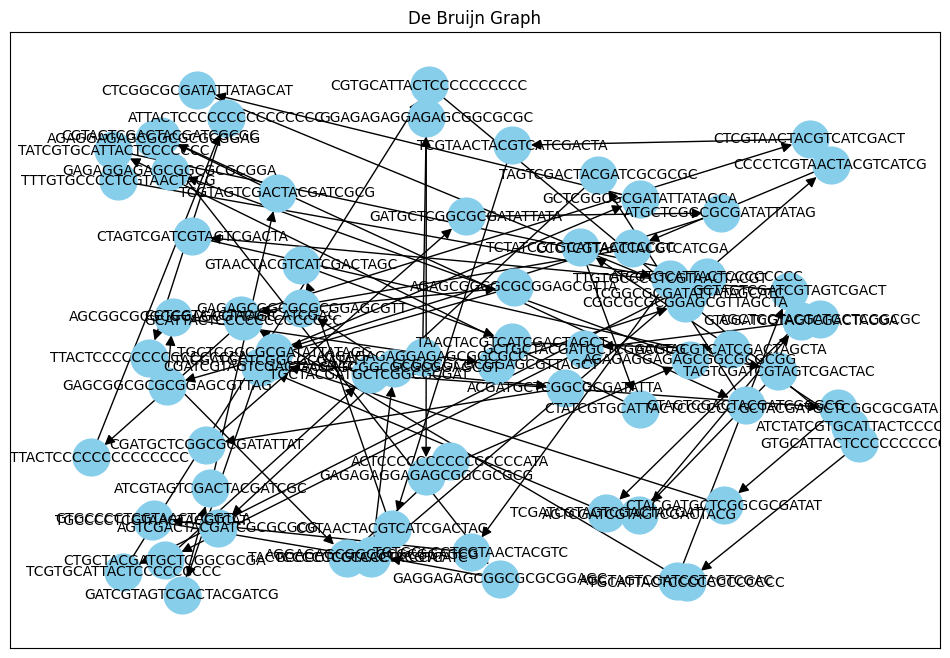

In [31]:
ut.visualize_de_bruijn_graph(dbg_1)
ut.visualize_de_bruijn_graph(dbg_2)

In [32]:
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import to_networkx, from_networkx

In [33]:
train_data = [dbg_1, dbg_2]

In [34]:
train_data_torch = list(map(lambda x: from_networkx(x), train_data))

In [35]:
train_data_torch[0]

Data(edge_index=[2, 96], num_nodes=102)

In [36]:
train_data_torch[1]

Data(edge_index=[2, 70], num_nodes=75)

In [37]:
train_labels = [0, 1]

In [38]:
train_dataset = ut.GraphsDataset(train_data_torch, train_labels)

In [19]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: [DataBatch(edge_index=[2, 166], num_nodes=177, batch=[177], ptr=[3]), tensor([0, 1])]
[DataBatch(edge_index=[2, 166], num_nodes=177, batch=[177], ptr=[3]), tensor([0, 1])]



In [26]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64, num_classes = len(train_labels))
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [27]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64, num_classes = len(train_labels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

AttributeError: 'list' object has no attribute 'x'

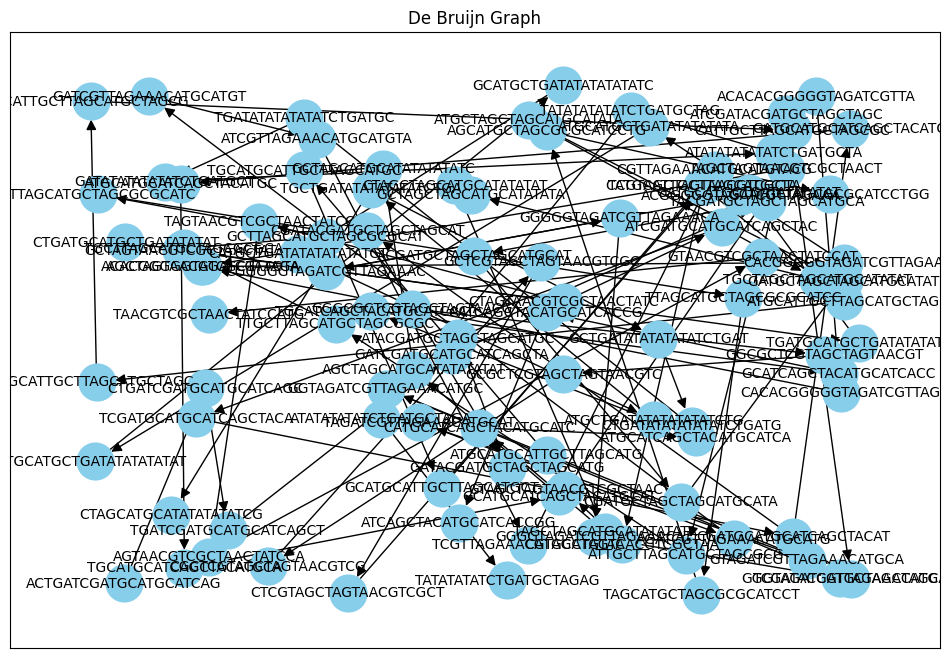

In [15]:
ut.visualize_de_bruijn_graph(dbg_1)

In [39]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [40]:
data

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [42]:
data_tss = train_data_torch[0]

In [44]:
data_tss.y = 0

In [45]:
data_tss

Data(edge_index=[2, 96], num_nodes=102, y=0)

In [47]:
train_data_torch[0]

Data(edge_index=[2, 96], num_nodes=102, y=0)

In [48]:
train_data_torch[1]

Data(edge_index=[2, 70], num_nodes=75)

In [51]:
train_data_torch[0].y = [0]

In [53]:
train_data_torch[0].y

[0]

In [50]:
data.y

tensor([1])

In [ ]:
data

In [23]:
data.num_node_features

7